# Main Project Notebook

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
# Needed for training
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
# Models
from models_part1 import FinalClassifier , MNISTAutoencoder, CIFAR10Autoencoder
from models_part2 import MNISTClassifyingAutoencoder,CIFAR10ClassifyingAutoencoder
from models_part3 import NTXentLoss,RandomNoise
from models_testing import  plot_accuracies,plot_losses,test_classifier,test_classifyingAutoEncoder
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# MNIST

## Preparing data

In [3]:
mnist_path = "./mnist_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [4]:
train_size = 50_000
val_size = 10_000

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


batch_size = 64

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

images, labels = next(iter(mnist_train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 1, 28, 28]), Labels: tensor([8, 9, 7, 3, 3])


## 1.2.1

In [5]:
# Model initialization
model = MNISTAutoencoder(latent_dim=128).to(device)

train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=25,
                       learning_rate=1e-4)

Epoch [1/25], Time: 16.42s, Train Loss: 0.7103, Val Loss: 0.5538, LR: 0.000100
Epoch [2/25], Time: 10.79s, Train Loss: 0.5471, Val Loss: 0.5202, LR: 0.000100
Epoch [3/25], Time: 9.76s, Train Loss: 0.5269, Val Loss: 0.5066, LR: 0.000100
Epoch [4/25], Time: 9.80s, Train Loss: 0.5175, Val Loss: 0.5006, LR: 0.000100
Epoch [5/25], Time: 10.43s, Train Loss: 0.5122, Val Loss: 0.4969, LR: 0.000100
Epoch [6/25], Time: 10.27s, Train Loss: 0.5085, Val Loss: 0.4942, LR: 0.000100
Epoch [7/25], Time: 10.22s, Train Loss: 0.5058, Val Loss: 0.4914, LR: 0.000100
Epoch [8/25], Time: 9.64s, Train Loss: 0.5037, Val Loss: 0.4895, LR: 0.000100
Epoch [9/25], Time: 9.77s, Train Loss: 0.5021, Val Loss: 0.4882, LR: 0.000100
Epoch [10/25], Time: 9.72s, Train Loss: 0.5006, Val Loss: 0.4868, LR: 0.000025
Epoch [11/25], Time: 9.64s, Train Loss: 0.4994, Val Loss: 0.4863, LR: 0.000025
Epoch [12/25], Time: 9.57s, Train Loss: 0.4990, Val Loss: 0.4861, LR: 0.000025
Epoch [13/25], Time: 9.79s, Train Loss: 0.4986, Val Loss

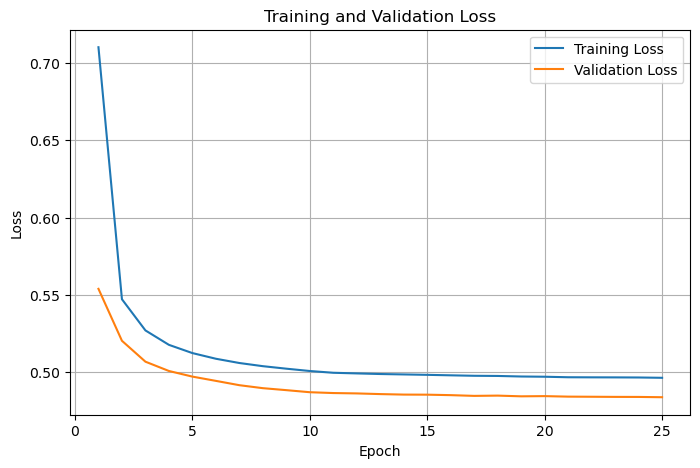

In [6]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [8]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=15, learning_rate=1e-3)


Epoch [1/15], Time: 13.04s, Train Loss: 0.1811, Train Accuracy: 94.50%, Val Accuracy: 96.95%, LR: 0.001000
Epoch [2/15], Time: 12.65s, Train Loss: 0.0901, Train Accuracy: 97.13%, Val Accuracy: 97.55%, LR: 0.001000
Epoch [3/15], Time: 12.39s, Train Loss: 0.0674, Train Accuracy: 97.84%, Val Accuracy: 97.82%, LR: 0.001000
Epoch [4/15], Time: 12.35s, Train Loss: 0.0609, Train Accuracy: 97.97%, Val Accuracy: 97.77%, LR: 0.001000
Epoch [5/15], Time: 12.39s, Train Loss: 0.0503, Train Accuracy: 98.34%, Val Accuracy: 98.01%, LR: 0.001000
Epoch [6/15], Time: 12.38s, Train Loss: 0.0456, Train Accuracy: 98.51%, Val Accuracy: 98.10%, LR: 0.001000
Epoch [7/15], Time: 12.36s, Train Loss: 0.0403, Train Accuracy: 98.69%, Val Accuracy: 97.91%, LR: 0.001000
Epoch [8/15], Time: 12.49s, Train Loss: 0.0372, Train Accuracy: 98.74%, Val Accuracy: 98.00%, LR: 0.001000
Epoch [9/15], Time: 12.46s, Train Loss: 0.0310, Train Accuracy: 98.95%, Val Accuracy: 98.15%, LR: 0.001000
Epoch [10/15], Time: 12.58s, Train Lo

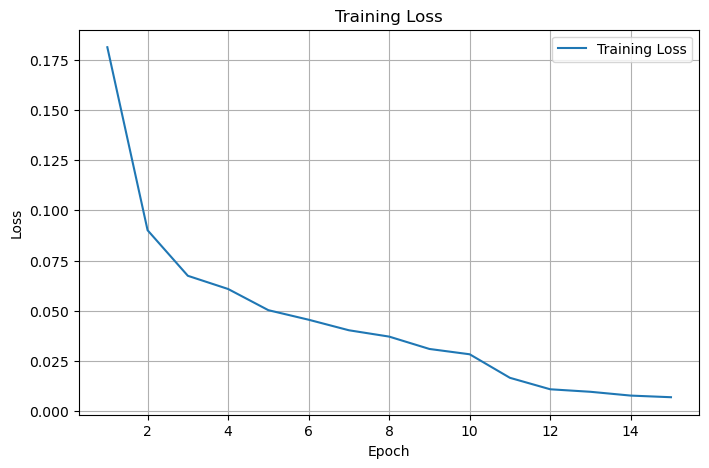

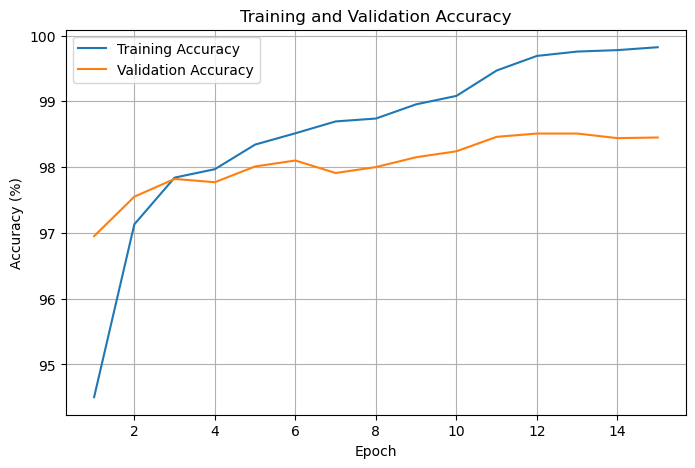

In [9]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [10]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 98.45%


## 1.2.2

In [11]:
# Model initialization
model = MNISTClassifyingAutoencoder(latent_dim=128).to(device)

train_losses, train_accuracies, val_accuracies = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=15,
                       learning_rate=1e-4)

Epoch [1/15], Time: 10.17s, Train Loss: 0.3248, Train Accuracy: 91.08%, Val Accuracy: 96.77%, LR: 0.000100
Epoch [2/15], Time: 9.94s, Train Loss: 0.0965, Train Accuracy: 97.21%, Val Accuracy: 97.80%, LR: 0.000100
Epoch [3/15], Time: 9.78s, Train Loss: 0.0624, Train Accuracy: 98.12%, Val Accuracy: 98.05%, LR: 0.000100
Epoch [4/15], Time: 9.81s, Train Loss: 0.0447, Train Accuracy: 98.61%, Val Accuracy: 98.25%, LR: 0.000100
Epoch [5/15], Time: 9.91s, Train Loss: 0.0331, Train Accuracy: 98.95%, Val Accuracy: 98.30%, LR: 0.000100
Epoch [6/15], Time: 9.90s, Train Loss: 0.0266, Train Accuracy: 99.19%, Val Accuracy: 98.63%, LR: 0.000100
Epoch [7/15], Time: 10.18s, Train Loss: 0.0203, Train Accuracy: 99.39%, Val Accuracy: 98.57%, LR: 0.000100
Epoch [8/15], Time: 9.76s, Train Loss: 0.0171, Train Accuracy: 99.48%, Val Accuracy: 98.50%, LR: 0.000100
Epoch [9/15], Time: 9.84s, Train Loss: 0.0141, Train Accuracy: 99.54%, Val Accuracy: 98.60%, LR: 0.000100
Epoch [10/15], Time: 9.87s, Train Loss: 0.01

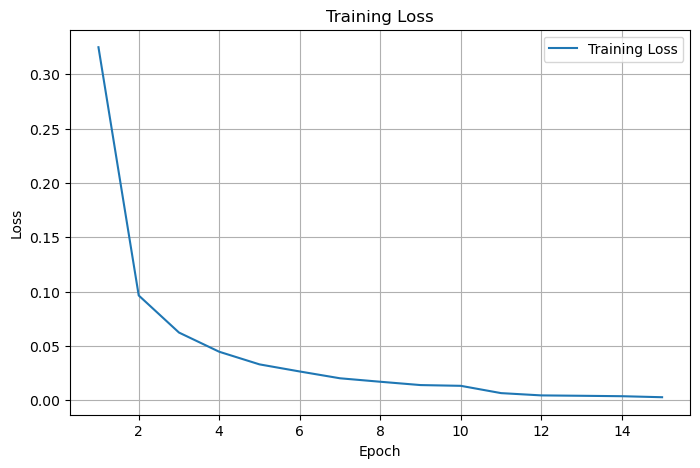

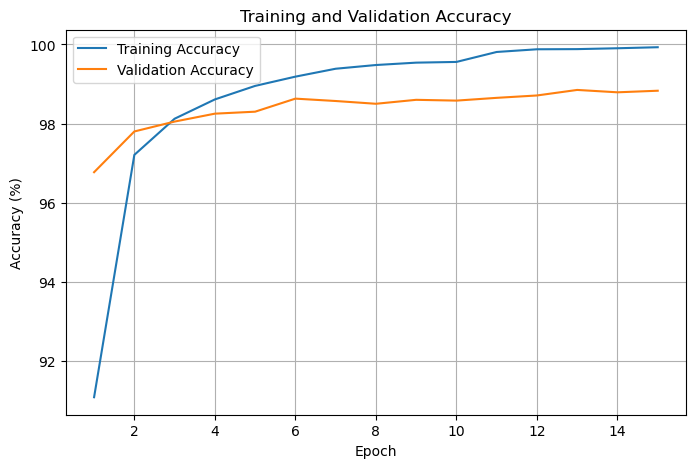

In [12]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [13]:
test_classifyingAutoEncoder(classifier=model,
                            test_loader=mnist_test_loader)

Test Accuracy: 98.71%


## 1.2.3

## Data Preparation and Augmentation

# Cifar10

## Preparing data

In [9]:
cifar10_path = "./cifar10_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # CIFAR-10 has 3 channels (RGB)
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [10]:
train_size = 40_000
val_size = 10_000

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")

# Define batch size
batch_size = 64

# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 3, 32, 32]), Labels (first 5): tensor([3, 3, 1, 2, 7])


## 1.2.1

In [5]:
model = CIFAR10Autoencoder(latent_dim=128).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=20,
                        learning_rate=1e-4)

Epoch [1/30], Time: 26.21s, Train Loss: 0.1800, Val Loss: 0.0830 , LR: 0.000100
Epoch [2/30], Time: 19.58s, Train Loss: 0.0870, Val Loss: 0.0650 , LR: 0.000100
Epoch [3/30], Time: 19.16s, Train Loss: 0.0756, Val Loss: 0.0568 , LR: 0.000100
Epoch [4/30], Time: 19.86s, Train Loss: 0.0707, Val Loss: 0.0521 , LR: 0.000100
Epoch [5/30], Time: 19.57s, Train Loss: 0.0677, Val Loss: 0.0498 , LR: 0.000100
Epoch [6/30], Time: 19.34s, Train Loss: 0.0657, Val Loss: 0.0474 , LR: 0.000100
Epoch [7/30], Time: 19.36s, Train Loss: 0.0643, Val Loss: 0.0468 , LR: 0.000100
Epoch [8/30], Time: 19.33s, Train Loss: 0.0631, Val Loss: 0.0452 , LR: 0.000100
Epoch [9/30], Time: 19.34s, Train Loss: 0.0623, Val Loss: 0.0440 , LR: 0.000100
Epoch [10/30], Time: 19.45s, Train Loss: 0.0616, Val Loss: 0.0427 , LR: 0.000025
Epoch [11/30], Time: 19.55s, Train Loss: 0.0604, Val Loss: 0.0421 , LR: 0.000025
Epoch [12/30], Time: 19.24s, Train Loss: 0.0603, Val Loss: 0.0421 , LR: 0.000025
Epoch [13/30], Time: 19.25s, Train Lo

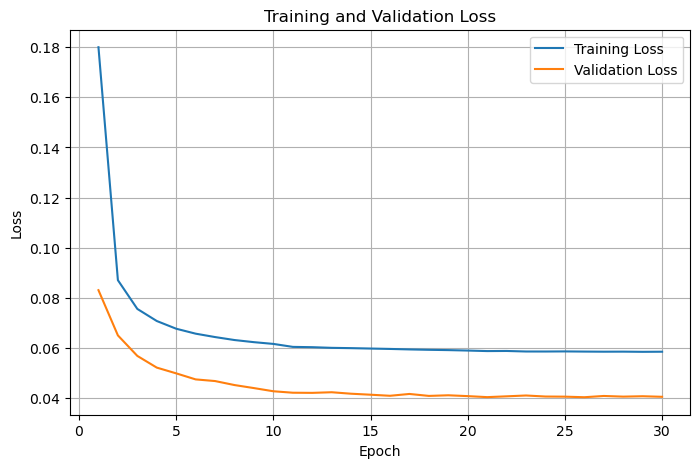

In [6]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [11]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=20, learning_rate=1e-3)

Epoch [1/20], Time: 54.58s, Train Loss: 1.5717, Train Accuracy: 43.97%, Val Accuracy: 48.70%, LR: 0.001000
Epoch [2/20], Time: 54.44s, Train Loss: 1.3749, Train Accuracy: 51.16%, Val Accuracy: 51.65%, LR: 0.001000
Epoch [3/20], Time: 54.22s, Train Loss: 1.2857, Train Accuracy: 54.04%, Val Accuracy: 53.30%, LR: 0.001000
Epoch [4/20], Time: 54.65s, Train Loss: 1.2237, Train Accuracy: 56.26%, Val Accuracy: 53.35%, LR: 0.001000
Epoch [5/20], Time: 53.91s, Train Loss: 1.1683, Train Accuracy: 58.30%, Val Accuracy: 53.36%, LR: 0.001000
Epoch [6/20], Time: 53.92s, Train Loss: 1.1190, Train Accuracy: 60.11%, Val Accuracy: 54.39%, LR: 0.001000
Epoch [7/20], Time: 53.75s, Train Loss: 1.0684, Train Accuracy: 62.13%, Val Accuracy: 53.86%, LR: 0.001000
Epoch [8/20], Time: 54.22s, Train Loss: 1.0231, Train Accuracy: 63.61%, Val Accuracy: 54.07%, LR: 0.001000
Epoch [9/20], Time: 55.86s, Train Loss: 0.9919, Train Accuracy: 64.75%, Val Accuracy: 54.59%, LR: 0.001000
Epoch [10/20], Time: 54.93s, Train Lo

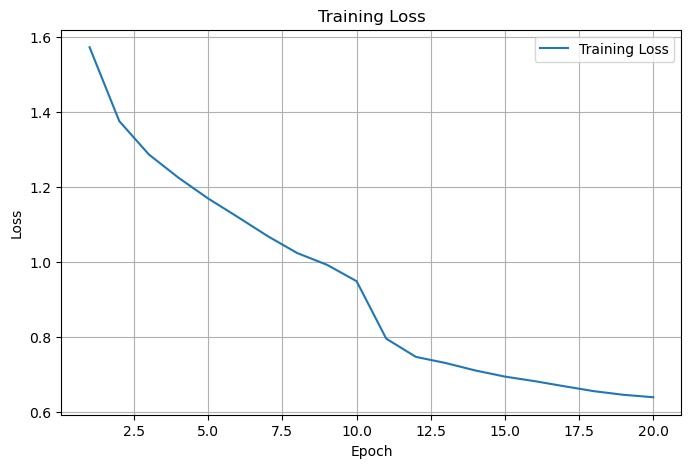

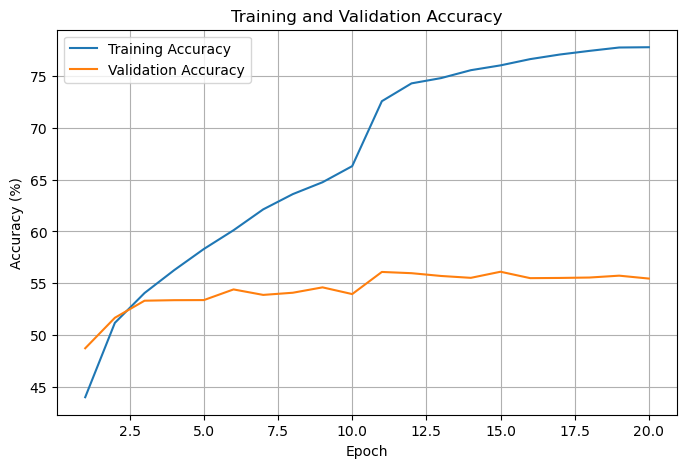

In [12]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [13]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)

Test Accuracy: 55.81%


## 1.2.2

In [14]:
# Model initialization
model = CIFAR10ClassifyingAutoencoder(latent_dim=128).to(device)

train_losses, train_accuracies, val_accuracies = model.train_autoencoder(train_loader= c10_train_loader,
                                                                         val_loader=c10_val_loader,
                                                                         num_epochs=25,
                                                                         learning_rate=1e-4)

Epoch [1/25], Time: 15.14s, Train Loss: 1.4981, Train Accuracy: 46.02%, Val Accuracy: 57.83%, LR: 0.000100
Epoch [2/25], Time: 14.86s, Train Loss: 1.0786, Train Accuracy: 61.59%, Val Accuracy: 64.77%, LR: 0.000100
Epoch [3/25], Time: 14.91s, Train Loss: 0.8723, Train Accuracy: 69.30%, Val Accuracy: 68.20%, LR: 0.000100
Epoch [4/25], Time: 14.77s, Train Loss: 0.7181, Train Accuracy: 75.14%, Val Accuracy: 68.05%, LR: 0.000100
Epoch [5/25], Time: 14.78s, Train Loss: 0.5969, Train Accuracy: 79.06%, Val Accuracy: 68.87%, LR: 0.000100
Epoch [6/25], Time: 14.82s, Train Loss: 0.4880, Train Accuracy: 83.31%, Val Accuracy: 68.77%, LR: 0.000100
Epoch [7/25], Time: 14.98s, Train Loss: 0.3851, Train Accuracy: 86.70%, Val Accuracy: 68.07%, LR: 0.000100
Epoch [8/25], Time: 14.73s, Train Loss: 0.3102, Train Accuracy: 89.25%, Val Accuracy: 68.08%, LR: 0.000100
Epoch [9/25], Time: 14.85s, Train Loss: 0.2448, Train Accuracy: 91.62%, Val Accuracy: 67.97%, LR: 0.000100
Epoch [10/25], Time: 14.91s, Train Lo

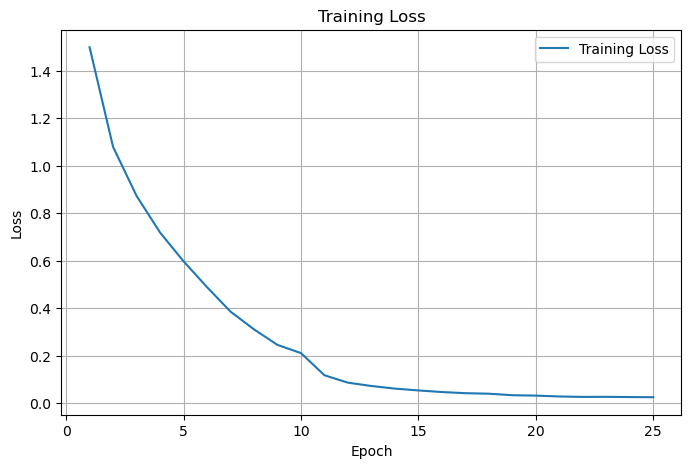

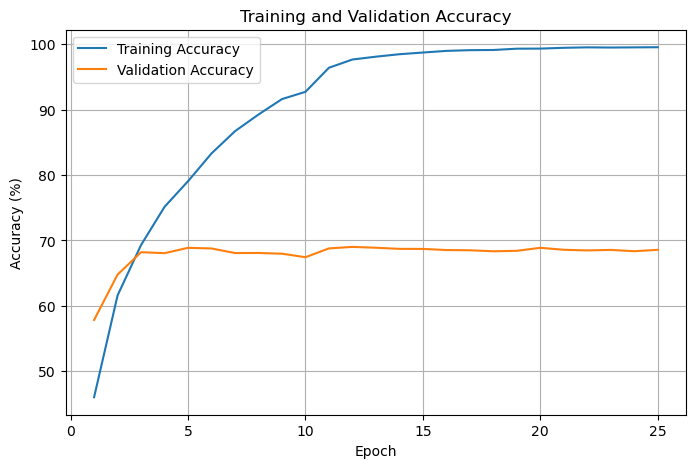

In [15]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [16]:
test_classifyingAutoEncoder(classifier=model,
                            test_loader=c10_test_loader)

Test Accuracy: 68.81%
